# Boston Housing
---

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
# from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
# from tensorflow.keras import metrics

%matplotlib inline
plt.style.use('seaborn')
rcParams['figure.figsize'] = (14,7)

In [2]:
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

## Exploratory Data Analysis

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

There are 506 total samples, 404 in the training set and 102 in the test set, which is about an 80/20 split.

The 13 features correspond to:
1. CRIM - per capita crime rate by town
2. ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS - proportion of non-retail business acres per town.
4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5. NOX - nitric oxides concentration (parts per 10 million)
6. RM - average number of rooms per dwelling
7. AGE - proportion of owner-occupied units built prior to 1940
8. DIS - weighted distances to five Boston employment centres
9. RAD - index of accessibility to radial highways
10. TAX - full-value property-tax rate per $10,000
11. PTRATIO - pupil-teacher ratio by town
12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT - % lower status of the population

With the single target variable being:
1. MEDV - Median value of owner-occupied homes in $1000's

Let's use some easier to understand names...

In [5]:
# features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
features = ['crime', 'zoned', 'industry', 'river', 'nox', 'rooms', 'age', 'distance', 'highways', 'tax', 'ptratio', 'blk', 'lower']

In [6]:
boston_train = pd.DataFrame(train_data, columns = features)
boston_train.head()

,crime,zoned,industry,river,nox,rooms,age,distance,highways,tax,ptratio,blk,lower
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65


In [7]:
boston_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 13 columns):
crime       404 non-null float64
zoned       404 non-null float64
industry    404 non-null float64
river       404 non-null float64
nox         404 non-null float64
rooms       404 non-null float64
age         404 non-null float64
distance    404 non-null float64
highways    404 non-null float64
tax         404 non-null float64
ptratio     404 non-null float64
blk         404 non-null float64
lower       404 non-null float64
dtypes: float64(13)
memory usage: 41.2 KB


Notice that the CHAS feature should be categorical.

In [8]:
# boston_train['CHAS'] = boston_train['CHAS'].astype('category')
boston_train['river'] = boston_train['river'].astype('category')
boston_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 13 columns):
crime       404 non-null float64
zoned       404 non-null float64
industry    404 non-null float64
river       404 non-null category
nox         404 non-null float64
rooms       404 non-null float64
age         404 non-null float64
distance    404 non-null float64
highways    404 non-null float64
tax         404 non-null float64
ptratio     404 non-null float64
blk         404 non-null float64
lower       404 non-null float64
dtypes: category(1), float64(12)
memory usage: 38.5 KB


In [9]:
boston_train.describe()

,crime,zoned,industry,nox,rooms,age,distance,highways,tax,ptratio,blk,lower
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


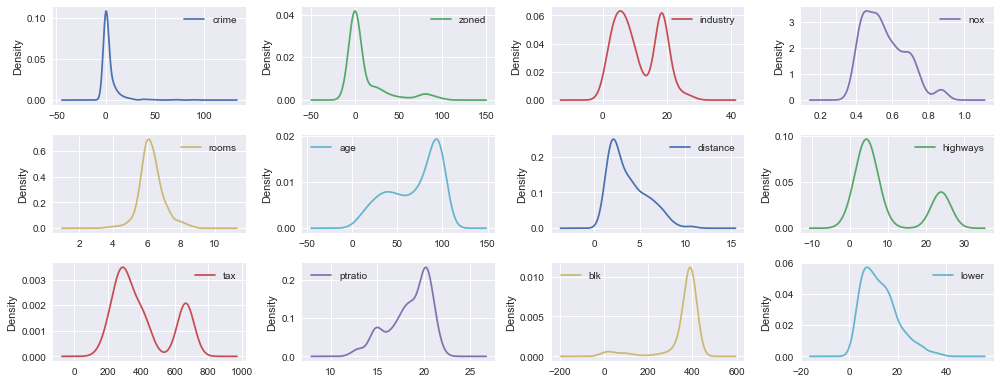

In [10]:
boston_train.plot(kind = 'density', subplots = True, layout = (4,4), sharex = False)
plt.tight_layout();

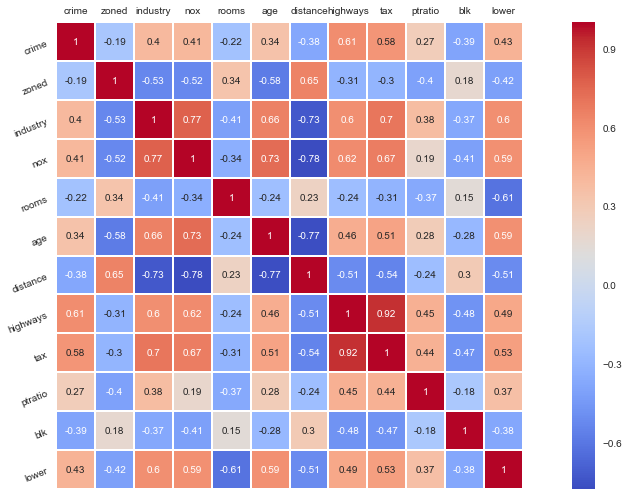

In [11]:
temp = boston_train.corr()
corr_ = pd.DataFrame(np.rot90(temp), columns = temp.columns, index = temp.columns[::-1]) # accounts for seaborn rotating the matrix
ax = sns.heatmap(corr_, cmap = 'coolwarm', linewidths = 1.0, square = True, annot = True)
ax.xaxis.set_ticks_position('top')
# fixes a current matplotlib issue when plotting seaborn heatmaps, top and bottom row are cut off
plt.ylim(0.0, len(corr_.columns))
plt.yticks(ticks = np.arange(0.5, len(corr_.columns), 1.0), rotation = 22.25)
plt.tight_layout()

Now let's have a quick look at the target variable, median value...

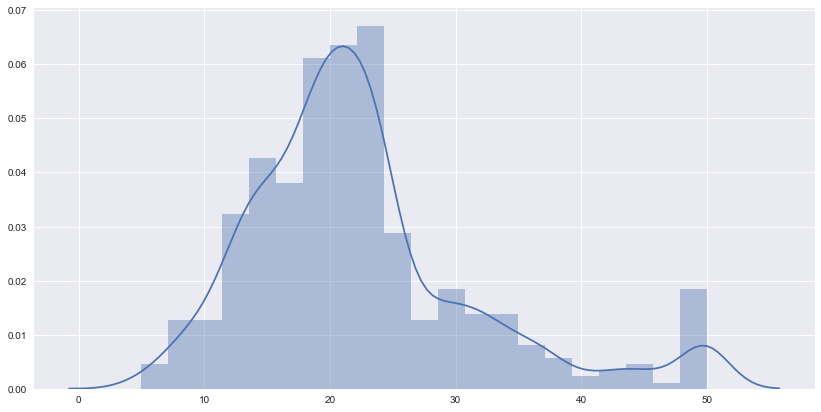

In [12]:
sns.distplot(train_targets);

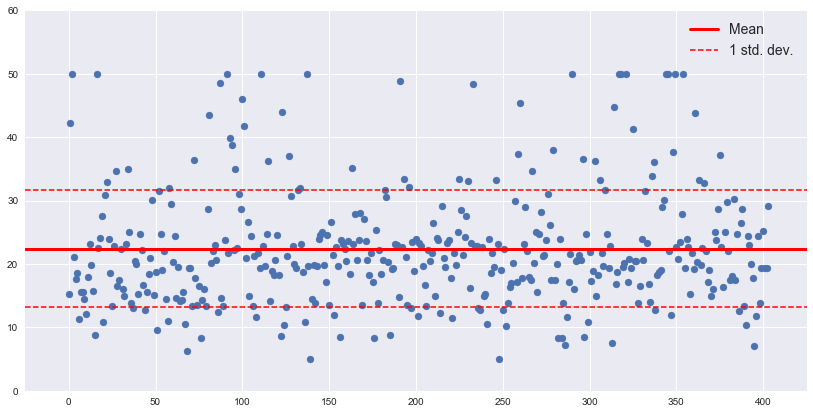

In [13]:
plt.scatter(x = range(len(train_targets)), y = train_targets)
plt.axhline(y = np.mean(train_targets), color = 'red', lw = 3, label = 'Mean')
plt.axhline(y = np.mean(train_targets) + np.std(train_targets), color = 'red', lw = 1.5, ls = '--', label = '1 std. dev.')
plt.axhline(y = np.mean(train_targets) - np.std(train_targets), color = 'red', lw = 1.5, ls = '--')
plt.legend(fontsize = 14, loc = 'upper right')
plt.xlim(-25,425)
plt.ylim(0, 60);

From the above two plots, we can see the median value is capped at $50k...

Let's see how correlated the features are to the target...

In [14]:
full = (pd.DataFrame(train_targets, columns = ['Median Value'])).join(boston_train)
target_corr = full.corr()
target_corr.iloc[:,0]

Median Value    1.000000
crime          -0.378498
zoned           0.380299
industry       -0.476743
nox            -0.438328
rooms           0.681483
age            -0.364173
distance        0.253900
highways       -0.375515
tax            -0.448737
ptratio        -0.493990
blk             0.343953
lower          -0.730793
Name: Median Value, dtype: float64

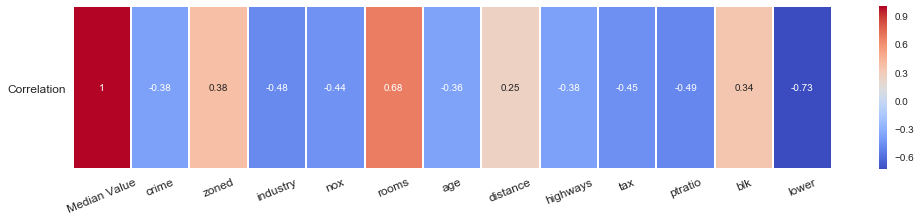

In [15]:
temp = pd.DataFrame(target_corr.iloc[:,0].values.T.reshape(1,13), columns = target_corr.columns)
temp.index = ['Correlation']
plt.figure(figsize = (17,3))
sns.heatmap(temp, cmap = 'coolwarm', annot = True, linewidths = 1.0)
plt.xticks(rotation = 22.5, fontsize = 12)
plt.yticks(rotation = 0, fontsize = 12);

---

In [16]:
# I'll center the data now since the features are on different scales and in different units.

mean = train_data.mean(axis = 0)
std = train_data.std(axis = 0)
train_data = (train_data - mean) / std

test_data = (test_data - mean) / std # be sure to normalize with training statistics and not test....

You may have just noticed that I normalized the categorical variable 'CHAS'. Debate is still open, but it scales the categorical variable with the other features, and it shouldn't affect the categories importance if it is scaled.

## Baseline model - Linear Regression
Creating a simple model first, and then seeing how much we can improve it or how it compares with other advanced models.

In [26]:
lm = LinearRegression()
lm.fit(train_data, train_targets)
predictions = lm.predict(test_data)

In [27]:
def plot_predictions(X_test, preds):
    data = pd.DataFrame([X_test, preds]).T
    data.columns = ['Actual', 'Predicted']
    data.sort_values(by = 'Actual', inplace = True)
    plt.fill_between(data['Actual'], data['Actual'] - 2*data['Predicted'].std(), data['Actual'] + 2*data['Predicted'].std(),
                     interpolate = True, alpha = 0.13)
    plt.errorbar(X_test, X_test, yerr = preds - X_test, alpha = 0.39)
    plt.scatter(data['Actual'], data['Predicted'], lw = 1.5, color = 'red')
    plt.xlabel('Actual', fontsize = 14)
    plt.ylabel('Predicted', fontsize = 14)
    plt.title('Actual vs Predicted', fontsize = 18)

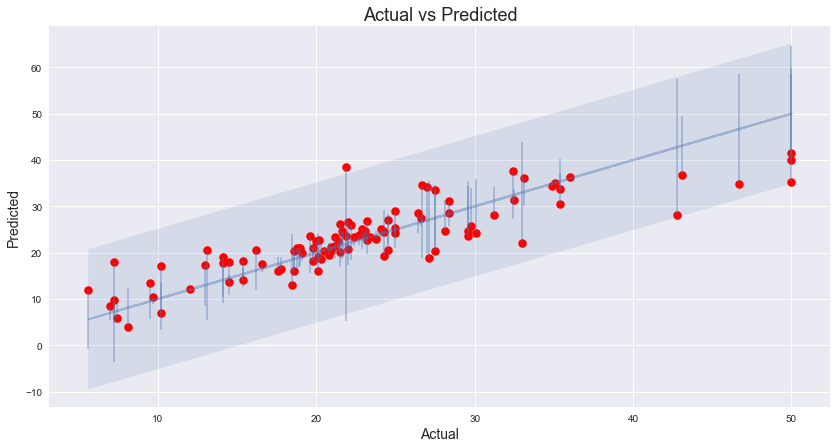

In [28]:
plot_predictions(test_targets, predictions)

In [30]:
baseline_mae =  metrics.mean_absolute_error(test_targets, predictions)
print('MAE:', metrics.mean_absolute_error(test_targets, predictions))
print('MSE:', metrics.mean_squared_error(test_targets, predictions))

MAE: 3.4641858124067166
MSE: 23.195599256422977


---

## Now let's see if we can improve using other Machine Learning Algorithms

#### To do... Add in description of models...

In [111]:
regressors = []
regressors.append(('Lasso', Lasso()))
regressors.append(('EN', ElasticNet()))
regressors.append(('Tree', DecisionTreeRegressor()))
regressors.append(('KNN', KNeighborsRegressor()))
regressors.append(('SVR', SVR()))
regressors.append(('RFR', RandomForestRegressor()))
regressors.append(('GBR', GradientBoostingRegressor()))
regressors.append(('ADA', AdaBoostRegressor()))

In [112]:
scorer = make_scorer(metrics.mean_absolute_error)

In [113]:
labels = ['Lasso', 'EN', 'Tree', 'KNN', 'SVR', 'RFR', 'GBR', 'ADA']
k = 4
N = 13
lasso_cv = pd.DataFrame(data = 0.0, columns = ['Fold ' + str(i) for i in range(1,k+1)], index = range(N))
en_cv = pd.DataFrame(data = 0.0, columns = ['Fold ' + str(i) for i in range(1,k+1)], index = range(N))
tree_cv = pd.DataFrame(data = 0.0, columns = ['Fold ' + str(i) for i in range(1,k+1)], index = range(N))
knn_cv = pd.DataFrame(data = 0.0, columns = ['Fold ' + str(i) for i in range(1,k+1)], index = range(N))
svr_cv = pd.DataFrame(data = 0.0, columns = ['Fold ' + str(i) for i in range(1,k+1)], index = range(N))
rfr_cv = pd.DataFrame(data = 0.0, columns = ['Fold ' + str(i) for i in range(1,k+1)], index = range(N))
gbr_cv = pd.DataFrame(data = 0.0, columns = ['Fold ' + str(i) for i in range(1,k+1)], index = range(N))
ada_cv = pd.DataFrame(data = 0.0, columns = ['Fold ' + str(i) for i in range(1,k+1)], index = range(N))

for i in range(N):
    for name, regressor in regressors:
        kfold = KFold(n_splits = k, shuffle = True)
        if name == 'Lasso':
            lasso_cv.iloc[i,:] = cross_val_score(regressor, train_data, train_targets, cv = kfold, scoring = scorer)
        if name == 'EN':
            en_cv.iloc[i,:] = cross_val_score(regressor, train_data, train_targets, cv = kfold, scoring = scorer)
        if name == 'Tree':
            tree_cv.iloc[i,:] = cross_val_score(regressor, train_data, train_targets, cv = kfold, scoring = scorer)
        if name == 'KNN':
            knn_cv.iloc[i,:] = cross_val_score(regressor, train_data, train_targets, cv = kfold, scoring = scorer)
        if name == 'SVR':
            svr_cv.iloc[i,:] = cross_val_score(regressor, train_data, train_targets, cv = kfold, scoring = scorer)
        if name == 'RFR':
            rfr_cv.iloc[i,:] = cross_val_score(regressor, train_data, train_targets, cv = kfold, scoring = scorer)
        if name == 'GBR':
            gbr_cv.iloc[i,:] = cross_val_score(regressor, train_data, train_targets, cv = kfold, scoring = scorer)
        if name == 'ADA':
            ada_cv.iloc[i,:] = cross_val_score(regressor, train_data, train_targets, cv = kfold, scoring = scorer)

In [120]:
named_cvs = zip(labels, [lasso_cv, en_cv, tree_cv, knn_cv, svr_cv, rfr_cv, gbr_cv, ada_cv])
cv_results = pd.DataFrame(data = 0.0, columns = labels, index = range(N*k))
for name, df in named_cvs:
    cv_results.loc[:,name] = pd.melt(df)['value']
cv_results.head()

,Lasso,EN,Tree,KNN,SVR,RFR,GBR,ADA
0,4.078804,4.485129,2.797030,2.630297,2.909212,2.445574,2.458636,2.967165
1,3.622463,4.106794,3.288119,2.561584,3.080967,2.334079,2.113300,3.224647
2,3.866972,4.165603,2.885149,3.090891,2.830841,2.347505,2.135502,3.173409
3,3.851984,4.599519,2.560396,3.224158,3.289827,1.993119,1.929188,2.431823
4,3.884017,4.399844,2.889109,3.072475,2.992691,2.266584,2.061612,2.610458


seaborn color palette 0 is blue, 1 is green, 2 is red. using here just to match colors, otherwise the caps would be black

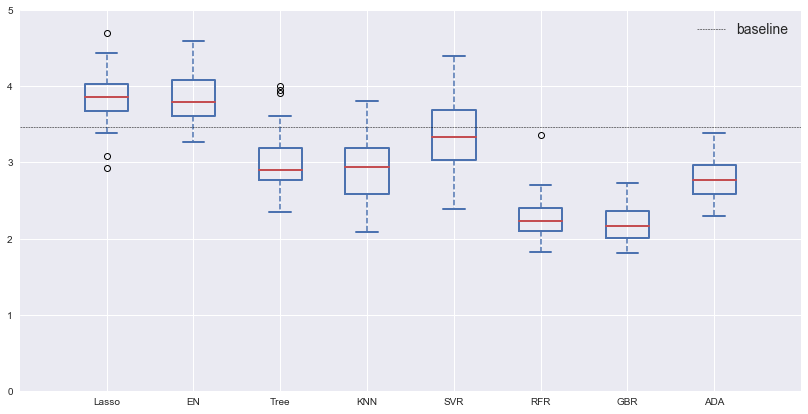

In [132]:
cv_results.boxplot(boxprops = dict(lw = 2.0), medianprops = dict(lw = 2.0),
                   whiskerprops = dict(lw = 1.5, ls = '--'), capprops = dict(lw = 2.0, color = sns.color_palette()[0]))
plt.axhline(y = baseline_mae, color = 'black', lw = 0.5, ls = '--', label = 'baseline')
plt.legend(fontsize = 14)
plt.xlim(0, 9)
plt.ylim(0, 5);

In [122]:
results = pd.DataFrame(data = 0.0, columns = ['MAE', 'MSE'], index = labels)
# fig, ax = plt.subplots(4,2)
for i, (name, regressor) in enumerate(regressors):
    regressor.fit(train_data, train_targets)
    predicts = regressor.predict(test_data)
    results.loc[name, 'MAE'] = metrics.mean_absolute_error(test_targets, predicts)
    results.loc[name, 'MSE'] = metrics.mean_squared_error(test_targets, predicts)
#     plot_predictions(test_targets, predicts)
results

,MAE,MSE
Lasso,3.488535,24.169260
EN,3.716988,26.889177
Tree,3.289216,21.198333
KNN,3.502353,30.227812
SVR,3.385399,27.241591
RFR,2.402235,13.891130
GBR,2.313639,12.647615
ADA,3.305217,19.703644


In [124]:
comparison = pd.DataFrame([cv_results.mean(), results['MAE']]).T
comparison.columns = ['CV Results', 'Test Results']
comparison['Abs. Diff'] = (comparison['CV Results'] - comparison['Test Results']).abs()
comparison

,CV Results,Test Results,Abs. Diff
Lasso,3.864477,3.488535,0.375942
EN,3.863698,3.716988,0.146710
Tree,2.981550,3.289216,0.307666
KNN,2.898621,3.502353,0.603731
SVR,3.370227,3.385399,0.015171
RFR,2.270929,2.402235,0.131306
GBR,2.197825,2.313639,0.115814
ADA,2.771941,3.305217,0.533276


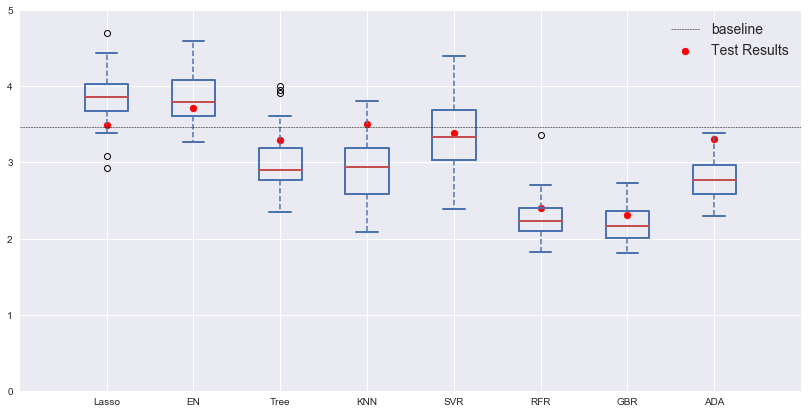

In [131]:
cv_results.boxplot(boxprops = dict(lw = 2.0), medianprops = dict(lw = 2.0),
                   whiskerprops = dict(lw = 1.5, ls = '--'), capprops = dict(lw = 2.0, color = sns.color_palette()[0]))
plt.scatter(x = range(1,9), y = results['MAE'].values, color = 'red', label = 'Test Results')
plt.axhline(y = baseline_mae, color = 'black', lw = 0.5, ls = '--', label = 'baseline')
plt.xticks(ticks = range(1,9), labels = labels)
plt.legend(fontsize = 14)
plt.xlim(0, 9)
plt.ylim(0, 5);

Hyperparameter tuning to see if we can improve our results anymore...

In [128]:
import warnings
warnings.filterwarnings('ignore')

In [129]:
param_grids = {}
param_grids['Lasso'] = {'alpha' : np.arange(0.05, 5.0, 0.1)}
param_grids['EN'] = {'alpha' : np.arange(0.05, 5.0, 0.1), 'l1_ratio' : np.arange(0, 1, 0.1)}
param_grids['Tree'] = {'max_depth' : [3, 7, 11, 17, 26]}
param_grids['KNN'] = {'n_neighbors' : np.arange(1,11,3)}
param_grids['SVR'] = {'C' : [1, 10, 100, 1000, 10000], 'gamma' : [0.01, 0.001, 0.0001]}
param_grids['RFR'] = {'n_estimators' : np.arange(5, 100, 5), 'max_depth' : [3, 7, 11, 17, 26]}
param_grids['GBR'] = {'alpha' : np.arange(0.1, 0.9, 0.1), 'n_estimators' : np.arange(50, 500, 50), 'max_depth' : [3, 7, 11, 17, 26]}
param_grids['ADA'] = {'n_estimators' : np.arange(50, 500, 50)}

In [130]:
best_estimators = []
best_scores = []

for name, regressor in regressors:
    param_grid = param_grids[name]
    model = GridSearchCV(regressor, param_grids[name], scoring = 'neg_mean_absolute_error')
    model.fit(train_data, train_targets)
    best_estimators.append(model.best_estimator_)
    best_scores.append(model.best_score_)

In [133]:
best_estimators

[Lasso(alpha=0.15000000000000002, copy_X=True, fit_intercept=True, max_iter=1000,
       normalize=False, positive=False, precompute=False, random_state=None,
       selection='cyclic', tol=0.0001, warm_start=False),
 ElasticNet(alpha=0.15000000000000002, copy_X=True, fit_intercept=True,
            l1_ratio=0.0, max_iter=1000, normalize=False, positive=False,
            precompute=False, random_state=None, selection='cyclic', tol=0.0001,
            warm_start=False),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=11,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'),
 KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_job

In [134]:
labels = ['Lasso', 'EN', 'Tree', 'KNN', 'SVR', 'RFR', 'GBR', 'ADA']

gs_results = pd.DataFrame(data = 0.0, columns = ['MAE', 'MSE'], index = labels)

for i, model in enumerate(best_estimators):
    predicts = model.predict(test_data)
    gs_results.loc[labels[i], 'MAE'] = metrics.mean_absolute_error(test_targets, predicts)
    gs_results.loc[labels[i], 'MSE'] = metrics.mean_squared_error(test_targets, predicts)
#     plot_predictions(test_targets, predicts)
gs_results

,MAE,MSE
Lasso,3.351359,22.206658
EN,3.336961,21.681164
Tree,3.332231,22.312195
KNN,3.410294,27.453725
SVR,2.347102,14.078457
RFR,2.461667,14.455474
GBR,2.218901,12.052712
ADA,3.141762,17.411094


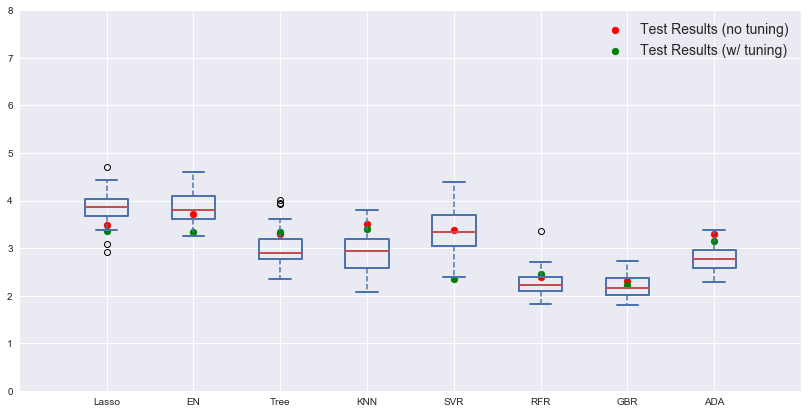

In [135]:
cv_results.boxplot(boxprops = dict(lw = 2.0), medianprops = dict(lw = 2.0),
                   whiskerprops = dict(lw = 1.5, ls = '--'), capprops = dict(lw = 2.0, color = sns.color_palette()[0]))
plt.scatter(x = range(1,9), y = results['MAE'].values, color = 'red', label = 'Test Results (no tuning)')
plt.scatter(x = range(1,9), y = gs_results['MAE'].values, color = 'green', label = 'Test Results (w/ tuning)')
plt.xticks(ticks = range(1,9), labels = labels)
plt.legend(fontsize = 14)
plt.xlim(0, 9)
plt.ylim(0, 8);

## Now let's see if a DNN can outperform these classical machine learning models

In [136]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1],)))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    return model

In [138]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 200
all_mae = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis = 0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs = num_epochs, batch_size = 1, verbose = False,
                        validation_data = (val_data, val_targets))
    # Evaluate the model on the validation data
    all_mae.append(history.history['val_mean_absolute_error'])

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [139]:
# averages each mae with the mae from a different fold but the same epoch
average_mae_history = [np.mean([x[i] for x in all_mae]) for i in range(num_epochs)]

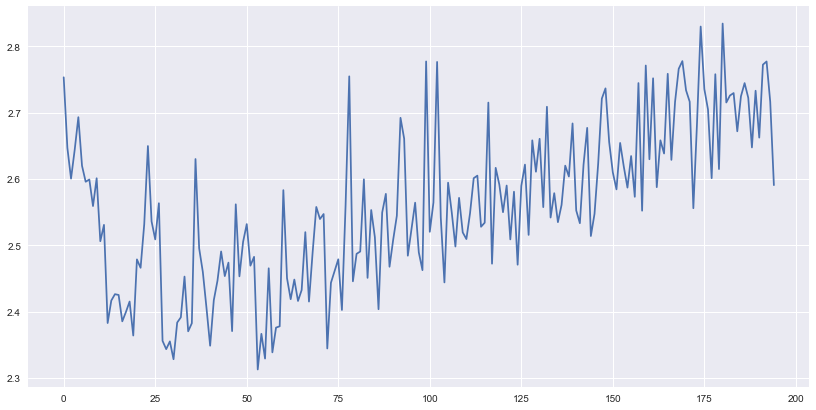

In [154]:
plt.plot(average_mae_history[5:]);

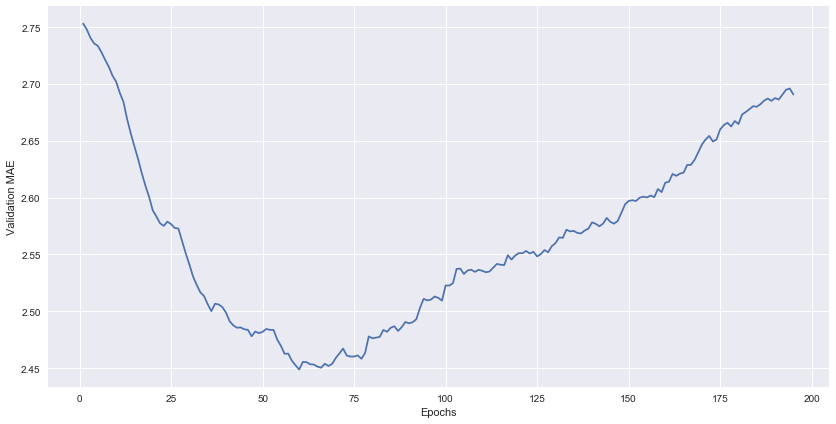

In [166]:
def smooth_curve(points, factor=0.95):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[5:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE');

In [170]:
test_mae = []
for i in range(10):
    model = build_model()
    model.fit(train_data, train_targets, epochs = 80, batch_size = 8, verbose = False)
    test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
    test_mae.append(test_mae_score)

102/102 [==============================] - 1s 6ms/sample - loss: 16.2732 - mean_absolute_error: 2.5189


In [171]:
np.mean(test_mae)

2.670134

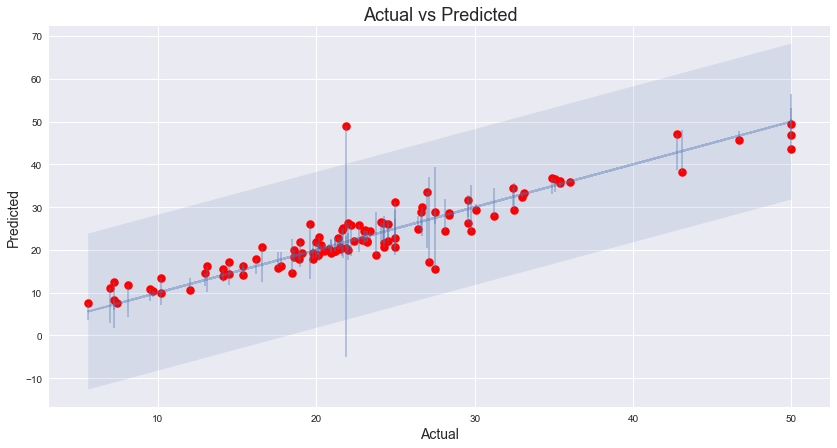

In [178]:
predictions = model.predict(test_data)
plot_predictions(test_targets, predictions.flatten())

---

See if we can improve the DNNs performance...

In [17]:
def build_model(n_hidden = 1, n_neurons = 64, activation = 'relu',
                learning_rate = 0.001, input_shape = (train_data.shape[1],)):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation = activation))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.RMSprop(lr = learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

In [18]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [24]:
param_grid = {'n_hidden' : np.arange(1, 11, 1),
              'n_neurons' : np.arange(0, 257, 32),
             'learning_rate' : [0.1, 0.01, 0.001, 0.0001],
             'activation' : ['relu', 'selu']}

In [28]:
grid_search_cv = RandomizedSearchCV(keras_reg, param_grid, cv = 4, n_iter = 7, scoring = 'neg_mean_absolute_error')

In [29]:
val_data = train_data[325:]
val_targets = train_targets[325:]

In [30]:
grid_search_cv.fit(train_data, train_targets, epochs = 100,
                  validation_data = (val_data, val_targets),
                  callbacks = [keras.callbacks.EarlyStopping(patience = 5)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 303 samples, validate on 79 samples
Epoch 1/100
303/303 [==============================] - 2s 8ms/sample - loss: 544.7989 - val_loss: 540.4797
Epoch 2/100
303/303 [==============================] - 0s 459us/sample - loss: 464.1898 - val_loss: 458.2525
Epoch 3/100
303/303 [==============================] - 0s 428us/sample - loss: 397.9956 - val_loss: 385.3982
Epoch 4/100
303/303 [==============================] - 0s 416us/sample - loss: 328.7781 - val_loss: 308.0213
Epoch 5/100
303/303 [==============================] - 0s 584us/sample - loss: 258.9513 - val_loss: 235.8560
Epoch 6/100
303/303 [==============================] - 0s 570us/sample - loss: 190.2516 - val_loss: 167.6055
Epoch 7/100
303/303 [==============================] - 0s 416us/sample - loss: 129.3724 - val_loss: 109.4766
Epoch 8/100
303/303 [==============================] - 0s 393us/sample - loss: 82.7212 - val_loss: 7

303/303 [==============================] - 0s 434us/sample - loss: 448.2365 - val_loss: 422.7092
Epoch 3/100
303/303 [==============================] - 0s 297us/sample - loss: 378.8088 - val_loss: 344.4429
Epoch 4/100
303/303 [==============================] - 0s 363us/sample - loss: 304.0177 - val_loss: 264.9299
Epoch 5/100
303/303 [==============================] - 0s 322us/sample - loss: 228.7776 - val_loss: 188.9679
Epoch 6/100
303/303 [==============================] - 0s 360us/sample - loss: 155.7373 - val_loss: 126.1082
Epoch 7/100
303/303 [==============================] - 0s 882us/sample - loss: 99.0186 - val_loss: 77.2265
Epoch 8/100
303/303 [==============================] - 0s 307us/sample - loss: 60.5192 - val_loss: 49.4642
Epoch 9/100
303/303 [==============================] - 0s 809us/sample - loss: 40.0329 - val_loss: 35.5190
Epoch 10/100
303/303 [==============================] - 0s 323us/sample - loss: 32.0229 - val_loss: 29.5826
Epoch 11/100
303/303 [================

303/303 [==============================] - 0s 407us/sample - loss: 8.4067 - val_loss: 8.4730
Epoch 79/100
303/303 [==============================] - 0s 634us/sample - loss: 9.1880 - val_loss: 8.2204
Epoch 80/100
303/303 [==============================] - 0s 402us/sample - loss: 8.5327 - val_loss: 7.1095
Epoch 81/100
303/303 [==============================] - 0s 388us/sample - loss: 8.8085 - val_loss: 7.8723
Epoch 82/100
303/303 [==============================] - 0s 431us/sample - loss: 8.0476 - val_loss: 7.9605
Epoch 83/100
303/303 [==============================] - 0s 753us/sample - loss: 8.7704 - val_loss: 7.2159
Epoch 84/100
303/303 [==============================] - 0s 424us/sample - loss: 8.1297 - val_loss: 6.8331
Epoch 85/100
303/303 [==============================] - 0s 357us/sample - loss: 8.4077 - val_loss: 7.9740
Epoch 86/100
303/303 [==============================] - 0s 353us/sample - loss: 8.3833 - val_loss: 6.9653
Epoch 87/100
303/303 [==============================] - 0s 

303/303 [==============================] - 0s 667us/sample - loss: 15.2330 - val_loss: 20.3090
Epoch 28/100
303/303 [==============================] - 0s 685us/sample - loss: 15.0763 - val_loss: 21.3969
Epoch 29/100
303/303 [==============================] - 0s 439us/sample - loss: 15.0597 - val_loss: 20.8726
Epoch 30/100
303/303 [==============================] - 0s 360us/sample - loss: 14.2365 - val_loss: 21.1658
Epoch 31/100
303/303 [==============================] - 0s 319us/sample - loss: 14.3293 - val_loss: 19.0416
Epoch 32/100
303/303 [==============================] - 0s 358us/sample - loss: 14.1274 - val_loss: 20.0957
Epoch 33/100
303/303 [==============================] - 0s 362us/sample - loss: 13.2625 - val_loss: 18.0302
Epoch 34/100
303/303 [==============================] - 0s 376us/sample - loss: 13.0222 - val_loss: 19.0368
Epoch 35/100
303/303 [==============================] - 0s 304us/sample - loss: 12.5828 - val_loss: 20.7770
Epoch 36/100
303/303 [===================

303/303 [==============================] - 0s 331us/sample - loss: 18.0388 - val_loss: 17.4888
Epoch 13/100
303/303 [==============================] - 0s 288us/sample - loss: 23.6638 - val_loss: 20.1403
Epoch 14/100
303/303 [==============================] - 0s 558us/sample - loss: 18.8053 - val_loss: 14.6406
Epoch 15/100
303/303 [==============================] - 0s 462us/sample - loss: 15.7464 - val_loss: 20.6064
Epoch 16/100
303/303 [==============================] - 0s 290us/sample - loss: 19.3973 - val_loss: 37.5737
Epoch 17/100
303/303 [==============================] - 0s 333us/sample - loss: 16.5157 - val_loss: 16.6114
Epoch 18/100
303/303 [==============================] - 0s 294us/sample - loss: 16.2548 - val_loss: 12.1606
Epoch 19/100
303/303 [==============================] - 0s 310us/sample - loss: 14.2997 - val_loss: 15.3863
Epoch 20/100
303/303 [==============================] - 0s 356us/sample - loss: 15.2635 - val_loss: 12.6183
Epoch 21/100
303/303 [===================

303/303 [==============================] - 0s 403us/sample - loss: 14.4187 - val_loss: 21.0074
Epoch 23/100
303/303 [==============================] - 0s 357us/sample - loss: 10.4421 - val_loss: 32.6736
Epoch 24/100
303/303 [==============================] - 0s 271us/sample - loss: 11.8040 - val_loss: 19.9122
Epoch 25/100
303/303 [==============================] - 0s 325us/sample - loss: 8.6399 - val_loss: 15.7709
Epoch 26/100
303/303 [==============================] - 0s 302us/sample - loss: 11.6572 - val_loss: 22.5642
Epoch 27/100
303/303 [==============================] - 0s 314us/sample - loss: 11.8665 - val_loss: 15.8797
Epoch 28/100
303/303 [==============================] - 0s 284us/sample - loss: 9.7295 - val_loss: 21.4818
Epoch 29/100
303/303 [==============================] - 0s 244us/sample - loss: 10.5619 - val_loss: 17.3284
Epoch 30/100
303/303 [==============================] - 0s 349us/sample - loss: 10.0660 - val_loss: 18.6717
Train on 303 samples, validate on 79 sample

303/303 [==============================] - 0s 261us/sample - loss: 11.0593 - val_loss: 9.2876
Epoch 68/100
303/303 [==============================] - 0s 135us/sample - loss: 11.0216 - val_loss: 9.2250
Epoch 69/100
303/303 [==============================] - 0s 126us/sample - loss: 10.9633 - val_loss: 9.0547
Epoch 70/100
303/303 [==============================] - 0s 211us/sample - loss: 10.7363 - val_loss: 9.0334
Epoch 71/100
303/303 [==============================] - 0s 145us/sample - loss: 10.7984 - val_loss: 9.0278
Epoch 72/100
303/303 [==============================] - 0s 149us/sample - loss: 10.6526 - val_loss: 8.8597
Epoch 73/100
303/303 [==============================] - 0s 155us/sample - loss: 10.6044 - val_loss: 8.9676
Epoch 74/100
303/303 [==============================] - 0s 142us/sample - loss: 10.4768 - val_loss: 9.0202
Epoch 75/100
303/303 [==============================] - 0s 168us/sample - loss: 10.7141 - val_loss: 8.8580
Epoch 76/100
303/303 [============================

303/303 [==============================] - 0s 231us/sample - loss: 13.1968 - val_loss: 11.9161
Epoch 43/100
303/303 [==============================] - 0s 195us/sample - loss: 12.8682 - val_loss: 11.4682
Epoch 44/100
303/303 [==============================] - 0s 152us/sample - loss: 12.6920 - val_loss: 10.8757
Epoch 45/100
303/303 [==============================] - 0s 136us/sample - loss: 12.3849 - val_loss: 10.6419
Epoch 46/100
303/303 [==============================] - 0s 185us/sample - loss: 11.9871 - val_loss: 10.3520
Epoch 47/100
303/303 [==============================] - 0s 149us/sample - loss: 11.8603 - val_loss: 10.1784
Epoch 48/100
303/303 [==============================] - 0s 172us/sample - loss: 11.6118 - val_loss: 9.8855
Epoch 49/100
303/303 [==============================] - 0s 149us/sample - loss: 11.4645 - val_loss: 10.0196
Epoch 50/100
303/303 [==============================] - 0s 163us/sample - loss: 11.3334 - val_loss: 9.6791
Epoch 51/100
303/303 [=====================

303/303 [==============================] - 0s 228us/sample - loss: 49.6315 - val_loss: 49.8005
Epoch 19/100
303/303 [==============================] - 0s 172us/sample - loss: 42.9943 - val_loss: 43.1312
Epoch 20/100
303/303 [==============================] - 0s 163us/sample - loss: 37.3989 - val_loss: 36.8211
Epoch 21/100
303/303 [==============================] - 0s 168us/sample - loss: 32.3207 - val_loss: 31.4997
Epoch 22/100
303/303 [==============================] - 0s 135us/sample - loss: 28.3659 - val_loss: 27.6739
Epoch 23/100
303/303 [==============================] - 0s 149us/sample - loss: 25.6582 - val_loss: 24.9590
Epoch 24/100
303/303 [==============================] - 0s 149us/sample - loss: 23.6464 - val_loss: 23.3763
Epoch 25/100
303/303 [==============================] - 0s 152us/sample - loss: 22.2149 - val_loss: 21.2030
Epoch 26/100
303/303 [==============================] - 0s 149us/sample - loss: 20.7381 - val_loss: 19.5854
Epoch 27/100
303/303 [===================

Epoch 95/100
303/303 [==============================] - 0s 180us/sample - loss: 7.4997 - val_loss: 6.5327
Epoch 96/100
303/303 [==============================] - 0s 172us/sample - loss: 7.4407 - val_loss: 7.0641
Epoch 97/100
303/303 [==============================] - 0s 165us/sample - loss: 7.5970 - val_loss: 6.8170
Epoch 98/100
303/303 [==============================] - 0s 172us/sample - loss: 7.4738 - val_loss: 6.6461
Epoch 99/100
303/303 [==============================] - 0s 185us/sample - loss: 7.3828 - val_loss: 6.9275
Epoch 100/100
303/303 [==============================] - 0s 154us/sample - loss: 7.3790 - val_loss: 7.3330
Train on 303 samples, validate on 79 samples
Epoch 1/100
303/303 [==============================] - 3s 9ms/sample - loss: 541.8387 - val_loss: 621.5970
Epoch 2/100
303/303 [==============================] - 0s 168us/sample - loss: 513.6174 - val_loss: 594.2014
Epoch 3/100
303/303 [==============================] - 0s 182us/sample - loss: 486.7424 - val_loss: 56

303/303 [==============================] - 0s 139us/sample - loss: 10.2754 - val_loss: 10.6876
Epoch 71/100
303/303 [==============================] - 0s 201us/sample - loss: 10.1493 - val_loss: 10.5615
Epoch 72/100
303/303 [==============================] - 0s 158us/sample - loss: 10.0432 - val_loss: 10.8561
Epoch 73/100
303/303 [==============================] - 0s 158us/sample - loss: 9.9240 - val_loss: 10.5591
Epoch 74/100
303/303 [==============================] - 0s 153us/sample - loss: 9.7717 - val_loss: 10.5781
Epoch 75/100
303/303 [==============================] - 0s 161us/sample - loss: 9.8430 - val_loss: 10.3506
Epoch 76/100
303/303 [==============================] - 0s 145us/sample - loss: 9.7178 - val_loss: 10.2369
Epoch 77/100
303/303 [==============================] - 0s 155us/sample - loss: 9.5781 - val_loss: 10.4945
Epoch 78/100
303/303 [==============================] - 0s 122us/sample - loss: 9.5321 - val_loss: 10.2311
Epoch 79/100
303/303 [=========================

303/303 [==============================] - 0s 417us/sample - loss: 24.9029 - val_loss: 20.1981
Epoch 21/100
303/303 [==============================] - 0s 399us/sample - loss: 12.0299 - val_loss: 11.7269
Epoch 22/100
303/303 [==============================] - 0s 416us/sample - loss: 13.1763 - val_loss: 33.7046
Epoch 23/100
303/303 [==============================] - 0s 422us/sample - loss: 15.6815 - val_loss: 9.4596
Epoch 24/100
303/303 [==============================] - 0s 335us/sample - loss: 19.0538 - val_loss: 7.9794
Train on 303 samples, validate on 79 samples
Epoch 1/100
303/303 [==============================] - 4s 12ms/sample - loss: 282.1165 - val_loss: 95.0330
Epoch 2/100
303/303 [==============================] - 0s 324us/sample - loss: 57.2444 - val_loss: 90.8220
Epoch 3/100
303/303 [==============================] - 0s 370us/sample - loss: 27.3954 - val_loss: 24.4138
Epoch 4/100
303/303 [==============================] - 0s 390us/sample - loss: 22.8736 - val_loss: 28.8047
Ep

Train on 303 samples, validate on 79 samples
Epoch 1/100
303/303 [==============================] - 4s 13ms/sample - loss: 503.7895 - val_loss: 388.4210
Epoch 2/100
303/303 [==============================] - 0s 812us/sample - loss: 274.7558 - val_loss: 165.8153
Epoch 3/100
303/303 [==============================] - 0s 1ms/sample - loss: 111.6374 - val_loss: 61.8391
Epoch 4/100
303/303 [==============================] - 0s 350us/sample - loss: 48.4421 - val_loss: 31.9422
Epoch 5/100
303/303 [==============================] - 0s 362us/sample - loss: 32.8985 - val_loss: 43.0559
Epoch 6/100
303/303 [==============================] - 0s 376us/sample - loss: 30.9935 - val_loss: 25.1132
Epoch 7/100
303/303 [==============================] - 0s 322us/sample - loss: 30.5068 - val_loss: 23.3045
Epoch 8/100
303/303 [==============================] - 0s 386us/sample - loss: 25.3702 - val_loss: 24.0651
Epoch 9/100
303/303 [==============================] - 0s 680us/sample - loss: 25.5972 - val_loss

303/303 [==============================] - 0s 122us/sample - loss: 582.4491 - val_loss: 641.3022
Epoch 18/100
303/303 [==============================] - 0s 117us/sample - loss: 582.0016 - val_loss: 640.8319
Epoch 19/100
303/303 [==============================] - 0s 116us/sample - loss: 581.5551 - val_loss: 640.3647
Epoch 20/100
303/303 [==============================] - 0s 112us/sample - loss: 581.1104 - val_loss: 639.8966
Epoch 21/100
303/303 [==============================] - 0s 109us/sample - loss: 580.6644 - val_loss: 639.4262
Epoch 22/100
303/303 [==============================] - 0s 110us/sample - loss: 580.2185 - val_loss: 638.9582
Epoch 23/100
303/303 [==============================] - 0s 122us/sample - loss: 579.7731 - val_loss: 638.4887
Epoch 24/100
303/303 [==============================] - 0s 119us/sample - loss: 579.3293 - val_loss: 638.0268
Epoch 25/100
303/303 [==============================] - 0s 116us/sample - loss: 578.8860 - val_loss: 637.5533
Epoch 26/100
303/303 [=

303/303 [==============================] - 0s 122us/sample - loss: 549.9430 - val_loss: 607.0894
Epoch 92/100
303/303 [==============================] - 0s 122us/sample - loss: 549.5087 - val_loss: 606.6345
Epoch 93/100
303/303 [==============================] - 0s 119us/sample - loss: 549.0771 - val_loss: 606.1787
Epoch 94/100
303/303 [==============================] - 0s 145us/sample - loss: 548.6442 - val_loss: 605.7198
Epoch 95/100
303/303 [==============================] - 0s 116us/sample - loss: 548.2106 - val_loss: 605.2660
Epoch 96/100
303/303 [==============================] - 0s 139us/sample - loss: 547.7813 - val_loss: 604.8103
Epoch 97/100
303/303 [==============================] - 0s 145us/sample - loss: 547.3488 - val_loss: 604.3638
Epoch 98/100
303/303 [==============================] - 0s 125us/sample - loss: 546.9225 - val_loss: 603.9083
Epoch 99/100
303/303 [==============================] - 0s 129us/sample - loss: 546.4910 - val_loss: 603.4583
Epoch 100/100
303/303 [

303/303 [==============================] - 0s 139us/sample - loss: 567.1031 - val_loss: 618.9923
Epoch 66/100
303/303 [==============================] - 0s 144us/sample - loss: 566.6730 - val_loss: 618.5361
Epoch 67/100
303/303 [==============================] - 0s 105us/sample - loss: 566.2400 - val_loss: 618.0686
Epoch 68/100
303/303 [==============================] - 0s 103us/sample - loss: 565.8033 - val_loss: 617.6216
Epoch 69/100
303/303 [==============================] - 0s 116us/sample - loss: 565.3720 - val_loss: 617.1606
Epoch 70/100
303/303 [==============================] - 0s 109us/sample - loss: 564.9369 - val_loss: 616.7015
Epoch 71/100
303/303 [==============================] - 0s 102us/sample - loss: 564.5009 - val_loss: 616.2443
Epoch 72/100
303/303 [==============================] - 0s 106us/sample - loss: 564.0665 - val_loss: 615.7757
Epoch 73/100
303/303 [==============================] - 0s 112us/sample - loss: 563.6272 - val_loss: 615.3263
Epoch 74/100
303/303 [=

303/303 [==============================] - 0s 139us/sample - loss: 589.4137 - val_loss: 631.0070
Epoch 40/100
303/303 [==============================] - 0s 119us/sample - loss: 588.9719 - val_loss: 630.5472
Epoch 41/100
303/303 [==============================] - 0s 116us/sample - loss: 588.5312 - val_loss: 630.0838
Epoch 42/100
303/303 [==============================] - 0s 109us/sample - loss: 588.0850 - val_loss: 629.6204
Epoch 43/100
303/303 [==============================] - 0s 122us/sample - loss: 587.6429 - val_loss: 629.1525
Epoch 44/100
303/303 [==============================] - 0s 119us/sample - loss: 587.1965 - val_loss: 628.6895
Epoch 45/100
303/303 [==============================] - 0s 116us/sample - loss: 586.7510 - val_loss: 628.2201
Epoch 46/100
303/303 [==============================] - 0s 125us/sample - loss: 586.3049 - val_loss: 627.7525
Epoch 47/100
303/303 [==============================] - 0s 122us/sample - loss: 585.8594 - val_loss: 627.2915
Epoch 48/100
303/303 [=

303/303 [==============================] - 0s 126us/sample - loss: 545.5558 - val_loss: 643.1737
Epoch 14/100
303/303 [==============================] - 0s 109us/sample - loss: 545.1241 - val_loss: 642.7043
Epoch 15/100
303/303 [==============================] - 0s 116us/sample - loss: 544.6959 - val_loss: 642.2362
Epoch 16/100
303/303 [==============================] - 0s 119us/sample - loss: 544.2663 - val_loss: 641.7641
Epoch 17/100
303/303 [==============================] - 0s 112us/sample - loss: 543.8320 - val_loss: 641.2913
Epoch 18/100
303/303 [==============================] - 0s 112us/sample - loss: 543.4004 - val_loss: 640.8209
Epoch 19/100
303/303 [==============================] - 0s 116us/sample - loss: 542.9688 - val_loss: 640.3458
Epoch 20/100
303/303 [==============================] - 0s 109us/sample - loss: 542.5364 - val_loss: 639.8821
Epoch 21/100
303/303 [==============================] - 0s 106us/sample - loss: 542.1085 - val_loss: 639.4080
Epoch 22/100
303/303 [=

303/303 [==============================] - 0s 112us/sample - loss: 514.2017 - val_loss: 608.9206
Epoch 88/100
303/303 [==============================] - 0s 119us/sample - loss: 513.7838 - val_loss: 608.4643
Epoch 89/100
303/303 [==============================] - 0s 109us/sample - loss: 513.3645 - val_loss: 608.0024
Epoch 90/100
303/303 [==============================] - 0s 106us/sample - loss: 512.9469 - val_loss: 607.5537
Epoch 91/100
303/303 [==============================] - 0s 119us/sample - loss: 512.5384 - val_loss: 607.1023
Epoch 92/100
303/303 [==============================] - 0s 115us/sample - loss: 512.1217 - val_loss: 606.6456
Epoch 93/100
303/303 [==============================] - 0s 122us/sample - loss: 511.7069 - val_loss: 606.1957
Epoch 94/100
303/303 [==============================] - 0s 135us/sample - loss: 511.2910 - val_loss: 605.7292
Epoch 95/100
303/303 [==============================] - 0s 138us/sample - loss: 510.8693 - val_loss: 605.2748
Epoch 96/100
303/303 [=

303/303 [==============================] - 0s 1ms/sample - loss: 6.2194 - val_loss: 4.5118
Epoch 37/100
303/303 [==============================] - 0s 669us/sample - loss: 5.4237 - val_loss: 3.2102
Epoch 38/100
303/303 [==============================] - 0s 653us/sample - loss: 4.6703 - val_loss: 6.5225
Epoch 39/100
303/303 [==============================] - 0s 657us/sample - loss: 5.7073 - val_loss: 3.1951
Epoch 40/100
303/303 [==============================] - 0s 660us/sample - loss: 5.7446 - val_loss: 3.7827
Epoch 41/100
303/303 [==============================] - 0s 661us/sample - loss: 8.0387 - val_loss: 5.3090
Epoch 42/100
303/303 [==============================] - 0s 838us/sample - loss: 6.3066 - val_loss: 4.7798
Epoch 43/100
303/303 [==============================] - 0s 786us/sample - loss: 5.2450 - val_loss: 4.7004
Epoch 44/100
303/303 [==============================] - 0s 639us/sample - loss: 4.8287 - val_loss: 2.9636
Epoch 45/100
303/303 [==============================] - 0s 65

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000021AFECFAE08>, as the constructor either does not set or modifies parameter n_neurons

In [31]:
grid_search_cv.best_params_

{'n_neurons': 32, 'n_hidden': 2, 'learning_rate': 0.001, 'activation': 'relu'}

In [32]:
grid_search_cv.best_score_

-2.446539222367919

In [36]:
model = grid_search_cv.estimator

In [38]:
predictions = grid_search_cv.predict(test_data)
metrics.mean_absolute_error(test_targets, predictions)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

to do... add initializers to param grid, include dropout?, try other optimizers?